In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import stan
import arviz as az

import nest_asyncio
nest_asyncio.apply()

In [2]:
insurance_data = pd.read_csv("./insurance.csv", sep=",", header=0)
insurance_data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [3]:
### Standardizing data
bmi = insurance_data.bmi
bmi -= bmi.mean()
bmi /= bmi.std()

age = insurance_data.age
age -= age.mean()
age /= age.std()

children = insurance_data.children
children -= children.mean()
children /= children.std()

charges = insurance_data.charges
charges -= charges.mean()
charges /= charges.std()

In [4]:
### Split Data into Train and Test
train_ratio = 0.9
train_index = int(insurance_data.shape[0] * train_ratio)

bmi_train = bmi[:train_index]
age_train = age[:train_index]
children_train = children[:train_index]
charges_train = charges[:train_index]

bmi_test = bmi[train_index:]
age_test = age[train_index:]
children_test = children[train_index:]
charges_test = charges[train_index:]

In [5]:
program_code = """
data {
    int<lower=1> N;
    vector[N] bmi;
    vector[N] age;
    vector[N] children;
    vector[N] y;
}

parameters {
    real<lower=0> sigma2;
    real alpha;
    real beta_bmi;
    real beta_age;
    real beta_children;
}

transformed parameters {
    real<lower=0> sigma;
    sigma = sqrt(sigma2);
}

model {
    alpha ~ normal(0, 5);
    beta_bmi ~ normal(0, 5);
    beta_age ~ normal(0, 5);
    beta_children ~ normal(0, 5);
    sigma ~ inv_gamma(1, 1);

    // Data model (likelihood)
    y ~ normal(alpha + beta_bmi * bmi + beta_age * age + beta_children * children, sigma);
}
"""

data_dict = {
    "N": train_index,
    "bmi": list(bmi_train),
    "age": list(age_train),
    "children": list(children_train),
    "y": list(charges_train)
}

model = stan.build(program_code, data=data_dict)

Building...



Building: found in cache, done.

In [6]:
fit = model.sample(num_chains=4, num_samples=2500, num_warmup=1000)

Sampling:   0%
Sampling:   2% (300/14000)
Sampling:   6% (800/14000)
Sampling:   9% (1300/14000)
Sampling:  32% (4500/14000)
Sampling:  54% (7500/14000)
Sampling:  75% (10500/14000)
Sampling: 100% (14000/14000)
Sampling: 100% (14000/14000), done.
Messages received during sampling:
  Gradient evaluation took 0.000261 seconds
  1000 transitions using 10 leapfrog steps per transition would take 2.61 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000283 seconds
  1000 transitions using 10 leapfrog steps per transition would take 2.83 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/tmp/httpstan_xhnzk1tz/model_mheusspa.stan', line 31, column 4 to column 90)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the

In [7]:
fit.to_frame().head()

parameters,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,sigma2,alpha,beta_bmi,beta_age,beta_children,sigma
draws,,,,,,,,,,,,,
0,-515.939207,0.783306,0.751909,3.0,7.0,0.0,519.451042,0.848335,-0.006161,0.152836,0.303379,0.046966,0.921051
1,-519.809336,0.978923,0.737544,3.0,7.0,0.0,522.141354,0.864328,0.002355,0.098702,0.300872,0.002310,0.929693
2,-516.403965,1.000000,0.810494,2.0,3.0,0.0,518.987051,0.855181,-0.021912,0.193004,0.299151,0.045638,0.924760
3,-517.201302,0.961215,0.772807,3.0,7.0,0.0,518.850288,0.853577,-0.021744,0.140011,0.314107,0.018997,0.923892
4,-517.375171,0.718469,0.751909,2.0,3.0,0.0,519.710232,0.908909,-0.057743,0.163841,0.282658,0.050331,0.953367


In [8]:
az.summary(fit)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
sigma2,0.869,0.036,0.799,0.934,0.0,0.0,12804.0,7052.0,1.0
alpha,-0.011,0.027,-0.062,0.037,0.0,0.0,13333.0,7887.0,1.0
beta_bmi,0.164,0.027,0.116,0.216,0.0,0.0,12055.0,7887.0,1.0
beta_age,0.273,0.027,0.224,0.325,0.0,0.0,11966.0,7138.0,1.0
beta_children,0.047,0.027,-0.003,0.098,0.0,0.0,12572.0,7851.0,1.0
sigma,0.932,0.019,0.897,0.969,0.0,0.0,12804.0,7052.0,1.0


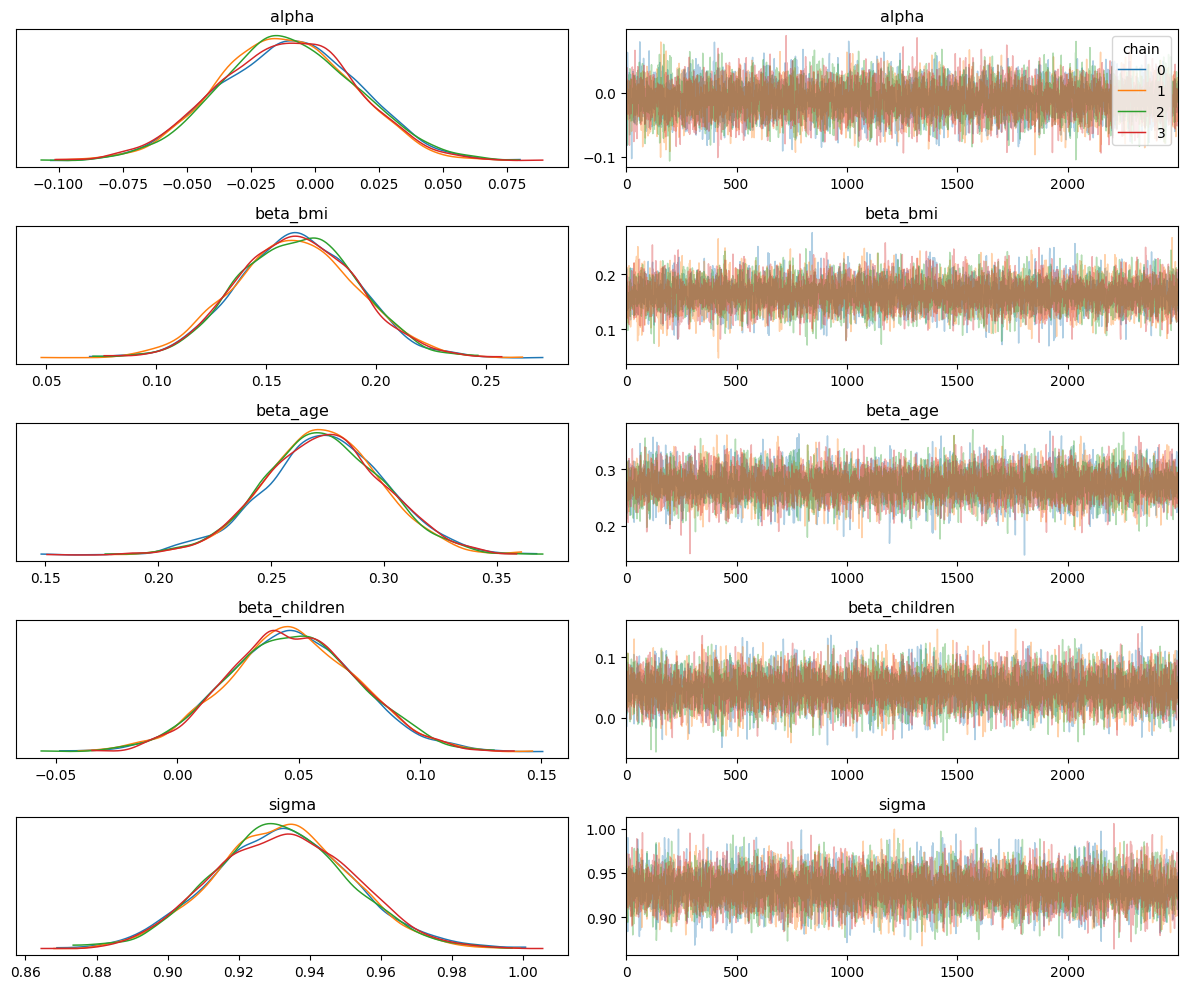

In [9]:
az.plot_trace(fit, var_names=['alpha', 'beta_bmi', "beta_age", "beta_children", "sigma"], compact=False, legend=True)
plt.tight_layout()

# Analysis

Based on the results of the model, a person's age is the best predictor because it has the most influence on the charges. The number of children has very little influence on the charges, so would make a poor predictor. The BMI has some influence, so would be a mediocre predictor, but the person's age is obviously the best.